# Downloading the Chest X-ray images
The chest X-ray images can be found in the image folder of dataset's online directory (https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345). The images are organised in 12 different archieve files which can be downloaded manually or by running the provided script file "batch_download_zips.py" inside the image folder. However, the total size of the images are around 45 GB. Extracting the files will require additional 45 GB free space. So, it will take total 90 GB disk spaces which is huge. The height and the width of the images are 1024 x 1024 but the densenet121 model from torchvision needs only 224 x 224 images. So the images are way too big for my need. Just downloading all the files first and then extrating them will cost me unnecessary bills if I do this in a cloud platform (i.e. AWS).

What I can do to reduce disk space requirement is to download one archieve file (which ranges from 1.9 to 3.9 GB in size individually), extract it and delete the archieve file immediately. Then I will resize the images to 256 x 256 which will reduce the file size significantly and then delete the original images. Then I will continue to the next archieve file and repeat the same process. The final folder of the resized images takes only aroung 3 GB space and the whole process requires upto 12 Gb only.

The following two cells will download and resize the images.

In [1]:
import shutil
import os
import urllib.request
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

src = 'images' # location of the extracted images
dst = 'resized_images' # location of the resized images

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    # download the archieve file
    print('downloading '+fn+'...')
    urllib.request.urlretrieve(link, fn)
    # extract
    print('extracting ...')
    shutil.unpack_archive(fn)
    os.remove(fn) # deletes the archieve file
    # resize
    print("resizing images ...")
    image_list = os.listdir(src) # makes a list of all the files in the src
    if not os.path.exists(dst):
        os.makedirs(dst)
    total = len(image_list)
    # resizing images
    for idx, image_file in enumerate(image_list):
        image = Image.open(os.path.join(src,image_file))
        image = image.resize((256, 256))
        image = image.save(os.path.join(dst, image_file))
        print('\rcompleted: '+str(idx+1)+'/'+str(total), end='')
    print()
    shutil.rmtree(src) # removes the original images

print("Done!")

downloading images_01.tar.gz...
extracting ...
resizing images ...
completed: 4999/4999
downloading images_02.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading images_03.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading images_04.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading images_05.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading images_06.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading images_07.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading images_08.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading images_09.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading images_10.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading images_11.tar.gz...
extracting ...
resizing images ...
completed: 10000/10000
downloading 

Now that all the files are downloaded, let's check the total size of the resized images.

In [3]:
size = 0
for filename in os.listdir(dst):
    size += os.path.getsize(os.path.join(dst, filename))
print(f"{dst} folder size: {size/1024/1024/1024: 0.2f} GB")  # size in byte / (to KB) / (to MB) / (to GB)

resized_images folder size:  2.99 GB


## Preparing directory tree

For loading the images using torchvision dataloader, I am going to arange the images in the following directory structure.
<pre>
    dataset/train/pneumonia/xxx.png
    dataset/train/pneumonia/xxx.png
    dataset/train/not_pneumonia/xxx.png
    dataset/train/not_pneumonia/xxx.png
    ...
    dataset/validation/pneumonia/xxx.png
    dataset/validation/pneumonia/xxx.png
    dataset/validation/not_pneumonia/xxx.png
    dataset/validation/not_pneumonia/xxx.png
    ...
    dataset/test/pneumonia/xxx.png
    dataset/test/pneumonia/xxx.png
    dataset/test/not_pneumonia/xxx.png
    dataset/test/not_pneumonia/xxx.png
    ...
</pre>

To copy the images from "resized_images" to the "dataset" folder following the above structure, I am going the run the following code. (I will keep the "resized_images" because if I change my train, test and validation sets, I will need to re-arrange the dataset directory.)

In [4]:
output_dir = "dataset"
source_dir = "resized_images"
# remove old directories
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
        
for dataset in ["train", "validation", "test"]:
    print("creating",dataset,"directory")
    
    # make new dir
    os.makedirs(os.path.join(output_dir, dataset, "Pneumonia"))
    os.makedirs(os.path.join(output_dir, dataset, "Not_Pneumonia"))
    
    df = pd.read_csv(dataset+".csv")
    total = len(df.index)
    for idx in df.index:
        src = os.path.join(source_dir, df.loc[idx, "Image Index"])
        if df.loc[idx, "Finding Labels"] == 1:
            dst = os.path.join(output_dir, dataset, "Pneumonia", df.loc[idx, "Image Index"])
            shutil.copy(src, dst)
        else:
            dst = os.path.join(output_dir, dataset, "Not_Pneumonia", df.loc[idx, "Image Index"])
            shutil.copy(src, dst)
            
        print('\rcompleted: '+str(idx+1)+'/'+str(total), end='')
    print()
    print(dataset,"directory created.")

creating train directory
completed: 95501/95501
train directory created.
creating validation directory
completed: 14431/14431
validation directory created.
creating test directory
completed: 2188/2188
test directory created.


## Checking some images

Let's see some of the sample images

In [5]:
import matplotlib.image as mpimg

In [6]:
def get_sample(dataset, idx=0, src='dataset'):
    """Returns Image location of one Positive sample and one Negative sample from the dataframe"""
    df = pd.read_csv(dataset+'.csv')
    pos = df[df['Finding Labels'] == 1]['Image Index'].iloc[idx]
    neg = df[df['Finding Labels'] == 0]['Image Index'].iloc[idx]
    
    pos = os.path.join(src, dataset, "Pneumonia", pos)
    neg = os.path.join(src, dataset, "Not_Pneumonia", neg)
    
    return pos, neg

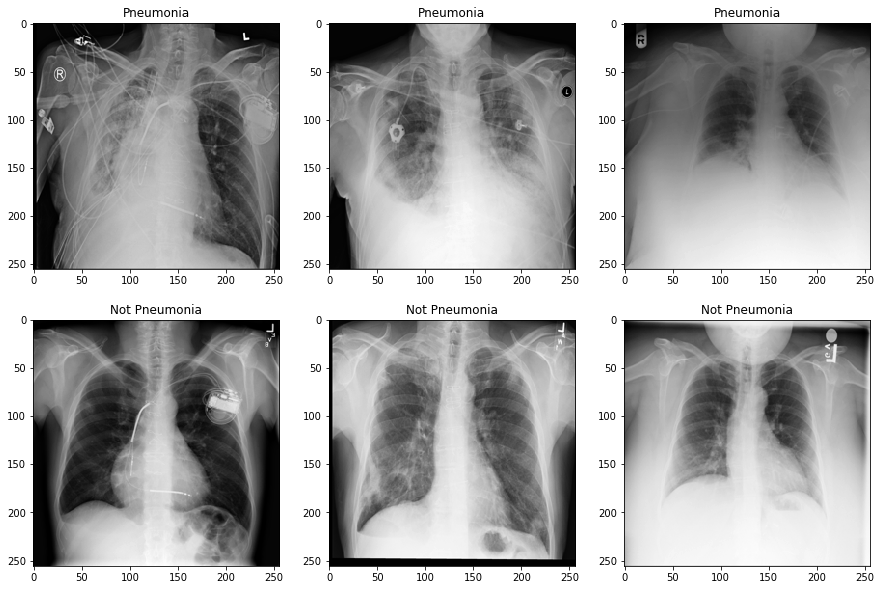

In [7]:
idx= 0 # set value to get different images
img_1, img_4 = get_sample('train', idx)
img_2, img_5 = get_sample('validation', idx)
img_3, img_6 = get_sample('test', idx)

# list of images
images = [img_1, img_2, img_3, img_4, img_5, img_6]

# plot
row = 2
col = 3
fig, ax = plt.subplots(row,col, figsize=(15,10))
for r in range(row):
    for c in range(col):
        img = mpimg.imread(images[c+r*3])
        ax[r,c].imshow(img, cmap='gray')
        label = 'Pneumonia' if (c+r*3) < 3 else 'Not Pneumonia'
        ax[r,c].set_title(label)

In the 3rd notebook, I will train my model.